In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install albumentations


In [4]:
import albumentations as A

transform = A.Compose([
    # A.RandomCrop(width=512, height=512),  # Uncomment if needed
    A.HorizontalFlip(p=0.5),  # 50% probability of horizontal flip
    # A.VerticalFlip(p=1),  # Uncomment if needed
    # A.RandomRotate90(p=1),  # Uncomment for random 90° rotations
    A.RandomBrightnessContrast(p=0.5),  # 50% probability for brightness/contrast
    A.Blur(blur_limit=7, always_apply=False, p=0.5),  # Use a valid p value
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, p=0.5),  # Jitter colors
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5),  # Add Gaussian noise
])


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-4-c54a26e35936>:9: UserWarning: Argument(s) 'always_apply' are not valid for transform Blur
  A.Blur(blur_limit=7, always_apply=False, p=0.5),  # Use a valid p value
<ipython-input-4-c54a26e35936>:11: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.5),  # Add Gaussian noise


Found 70 image-mask pairs.
Training set: (490, 256, 256, 3), (490, 256, 256, 1)
Validation set: (140, 256, 256, 3), (140, 256, 256, 1)
Test set: (70, 256, 256, 3), (70, 256, 256, 1)


<ipython-input-5-7dee49c3c119>:68: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(x_train[0])
<ipython-input-5-7dee49c3c119>:71: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(y_train[0, :, :, 0], cmap='gray')
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


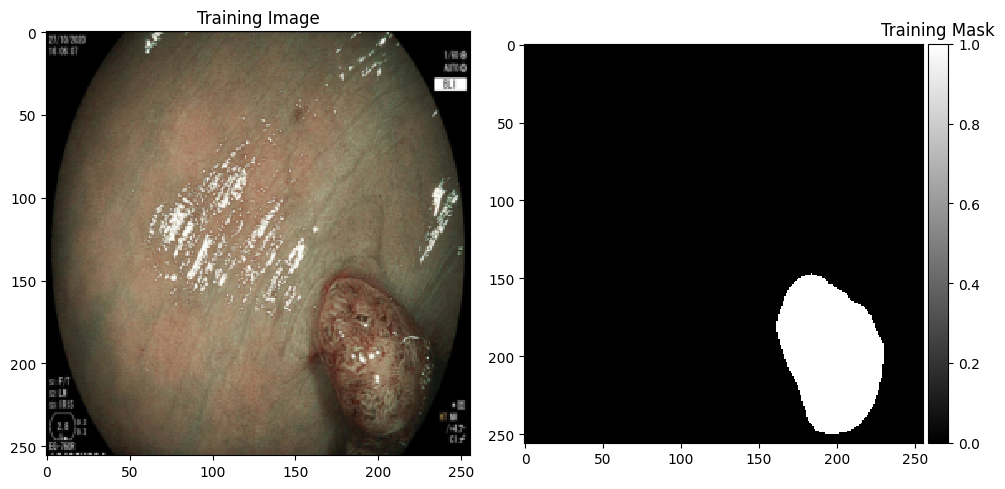

In [5]:
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define dataset paths
image_dir = '/content/drive/MyDrive/PolypDB/PolypDB/PolypDB_modality_wise/BLI/images'
mask_dir = '/content/drive/MyDrive/PolypDB/PolypDB/PolypDB_modality_wise/BLI/masks'

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256
CHANNELS = 3
TARGET_SIZE = 700  # Augmented dataset size

# Get sorted file lists
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Check image-mask consistency
if len(image_files) != len(mask_files):
    print(f"Warning: Image-mask count mismatch. Images: {len(image_files)}, Masks: {len(mask_files)}")
else:
    print(f"Found {len(image_files)} image-mask pairs.")

def load_and_preprocess(index):
    """Load, resize, and preprocess an image-mask pair."""
    image_path = os.path.join(image_dir, image_files[index])
    mask_path = os.path.join(mask_dir, mask_files[index])

    image = imread(image_path)
    mask = imread(mask_path, as_gray=True)

    # Ensure correct shape (for RGBA images)
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)

    # Convert mask to binary
    mask = (mask > 0.5).astype(np.uint8)

    return (image * 255).astype(np.uint8), mask

# Allocate arrays
aug_x_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8)
aug_y_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

# Load images
for count in range(TARGET_SIZE):
    index = count % len(image_files)  # Cyclic repeat
    aug_x_train[count], aug_y_train[count, :, :, 0] = load_and_preprocess(index)

# Split dataset (70% train, 20% val, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(aug_x_train, aug_y_train, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

# Print dataset shapes
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

# Display a sample
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(x_train[0])
plt.title("Training Image")
plt.subplot(1, 2, 2)
imshow(y_train[0, :, :, 0], cmap='gray')
plt.title("Training Mask")
plt.show()


In [6]:
np.save("/content/aug_x_train.npy", aug_x_train)
np.save("/content/aug_y_train.npy", aug_y_train)


In [7]:
import cv2

output_dir = "/content/augmented_data"
os.makedirs(output_dir, exist_ok=True)

for i in range(TARGET_SIZE):
    img_path = os.path.join(output_dir, f"image_{i}.png")
    mask_path = os.path.join(output_dir, f"mask_{i}.png")

    cv2.imwrite(img_path, aug_x_train[i])
    cv2.imwrite(mask_path, aug_y_train[i])


In [8]:
print(f"Train: {len(x_train)}, Val: {len(x_val)}, Test: {len(x_test)}")

Train: 490, Val: 140, Test: 70


In [9]:
print("X_train shape:", x_train.shape)  # (batch_size, 256, 256, 3)
print("y_train shape:", y_train.shape)  # Should be (batch_size, 256, 256, 1)


X_train shape: (490, 256, 256, 3)
y_train shape: (490, 256, 256, 1)


In [10]:
IMG_SIZE=256

In [11]:
def unet_resnet34(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    # Use ResNet50 instead of ResNet34
    base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_size)

    # Encoder (ResNet50) - Adjust layer names accordingly
    s1 = base_model.get_layer("conv1_relu").output  # Example layer, adjust as needed
    s2 = base_model.get_layer("conv2_block3_out").output  # Example layer, adjust as needed
    s3 = base_model.get_layer("conv3_block4_out").output  # Example layer, adjust as needed
    s4 = base_model.get_layer("conv4_block6_out").output  # Example layer, adjust as needed
    b5 = base_model.get_layer("conv5_block3_out").output  # Example layer, adjust as needed

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(b5)
    u6 = concatenate([u6, s4])
    c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, s3])
    c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, s2])
    c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, s1])
    c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Add another upsampling layer to reach 256x256
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c9)
    c10 = Conv2D(32, (3, 3), activation="relu", padding="same")(u10)
    c10 = Conv2D(32, (3, 3), activation="relu", padding="same")(c10)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c10)  # Output layer connected to u10

    return Model(inputs=base_model.input, outputs=outputs)


model = unet_resnet34()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 40,996,673 (156.39 MB)

 Trainable params: 40,943,553 (156.19 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
import tensorflow.keras.backend as K

smooth = 1

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)
# Create the metric objects outside the functions
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 2 * ((p * r) / (p + r + 1e-6))

def f2_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 5 * ((p * r) / ((4 * p) + r + 1e-6))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))  # Cast y_true to float32
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# In your model.compile call:
model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=[iou,dice_coef, f1_score, f2_score, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=7,            # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore best model weights
)

# Compile the model (assuming bce_dice_loss, iou, f1_score, etc., are defined)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=[iou, f1_score, f2_score, Precision(), Recall()])

# Train the model with Early Stopping
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stopping]  # Add the Early Stopping callback
)


Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - dice_coef: 0.0973 - f1_score: 0.0349 - f2_score: 0.0632 - iou: 0.0535 - loss: 1.3269 - precision_1: 0.0453 - recall_1: 0.2125 - val_dice_coef: 0.0644 - val_f1_score: 0.0309 - val_f2_score: 0.0200 - val_iou: 0.0349 - val_loss: 3.6844 - val_precision_1: 1.0000 - val_recall_1: 0.0188
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 279ms/step - dice_coef: 0.6605 - f1_score: 0.7312 - f2_score: 0.7004 - iou: 0.5112 - loss: 0.4067 - precision_1: 0.8579 - recall_1: 0.6875 - val_dice_coef: 0.8204 - val_f1_score: 0.8313 - val_f2_score: 0.8347 - val_iou: 0.7018 - val_loss: 0.2484 - val_precision_1: 0.8393 - val_recall_1: 0.8634
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - dice_coef: 0.8852 - f1_score: 0.8955 - f2_score: 0.8982 - iou: 0.7966 - loss: 0.1478 - precision_1: 0.9032 - recall_1: 0.9074 - val_dice_coef: 0.8796 - val_f1_score: 0.8908 - val_f2_score: 0.8630 - val_iou: 0.7894 - val_loss: 0.1434 - val_precision_1: 0.9582 - val_recall_1

In [14]:
y_pred = model.predict(x_test)  # Predict masks for test images


3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step


In [15]:
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)  # Convert probability map to binary mask


In [16]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("y_pred_thresholded shape:", y_pred_thresholded.shape)


x_test shape: (70, 256, 256, 3)
y_test shape: (70, 256, 256, 1)
y_pred shape: (70, 256, 256, 1)
y_pred_thresholded shape: (70, 256, 256, 1)


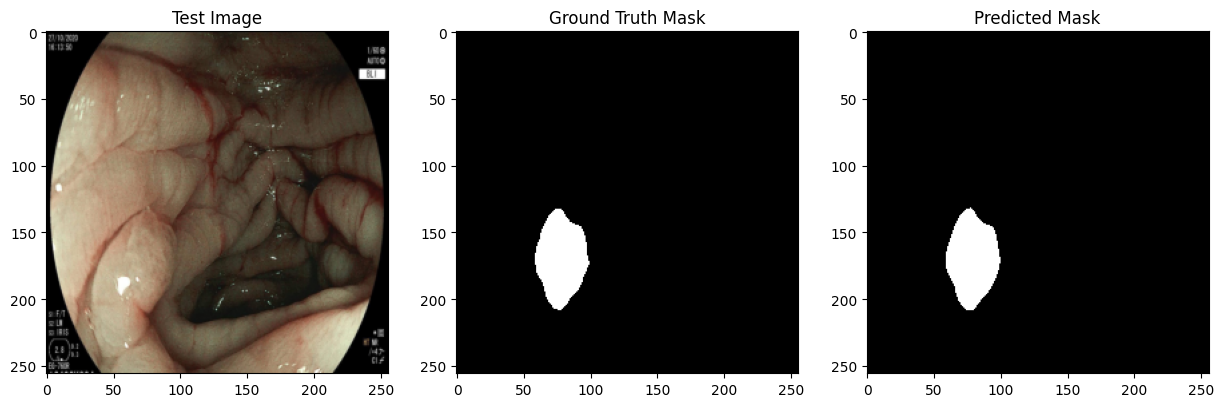

In [17]:
import matplotlib.pyplot as plt
import random

# Select a random test image
index = random.randint(0, len(x_test) - 1)

plt.figure(figsize=(15, 5))

# Original test image
plt.subplot(1, 3, 1)
plt.imshow(x_test[index])
plt.title("Test Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[index, :, :, 0], cmap='gray')
plt.title("Ground Truth Mask")

# Predicted mask (thresholded)
plt.subplot(1, 3, 3)
plt.imshow(y_pred_thresholded[index, :, :, 0], cmap='gray')
plt.title("Predicted Mask")

plt.show()


In [18]:
# Lists to store scores
dice_scores = []
iou_scores = []

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice and IoU for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming `iou` is your IoU function

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")


Mean Dice Score: 0.9860
Mean IoU Score: 0.9727


In [19]:
import tensorflow as tf

# Lists to store scores
dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []

# Initialize the Keras Precision and Recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice, IoU, Precision, and Recall for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming `iou` is your IoU function

    # Update the Precision and Recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Final Precision and Recall after iterating through all test samples
mean_precision = precision_metric.result().numpy()
mean_recall = recall_metric.result().numpy()

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")


Mean Dice Score: 0.9860
Mean IoU Score: 0.9727
Mean Precision: 0.9876
Mean Recall: 0.9972


In [20]:
import tensorflow as tf
import numpy as np

# Lists to store scores
dice_scores = []
iou_scores = []

# Initialize the Keras Precision and Recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice, IoU, Precision, and Recall for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming iou is your IoU function

    # Update the Precision and Recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Final Precision and Recall after iterating through all test samples
mean_precision = precision_metric.result().numpy()
mean_recall = recall_metric.result().numpy()

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Compute F1 and F2 scores
if mean_precision + mean_recall > 0:
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
    f2_score = 5 * (mean_precision * mean_recall) / (4 * mean_precision + mean_recall)
else:
    f1_score, f2_score = 0.0, 0.0  # Avoid division by zero

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"F2 Score: {f2_score:.4f}")


Mean Dice Score: 0.9860
Mean IoU Score: 0.9727
Mean Precision: 0.9876
Mean Recall: 0.9972
F1 Score: 0.9924
F2 Score: 0.9953


In [ ]:
model.save('/content/model.h5')  # Saves architecture, weights, and optimizer state


In [21]:
model.save('/content/drive/My Drive/BLIresunet.h5')  # Saves model to Drive


In [23]:
model.save('/content/drive/My Drive/BLIresunet.keras')  # Saves model to Drive


In [24]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/BLIresunet.h5', compile=False)


In [25]:
import tensorflow as tf
import numpy as np

# Lists to store scores
dice_scores = []
iou_scores = []

# Initialize the Keras Precision and Recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice, IoU, Precision, and Recall for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming iou is your IoU function

    # Update the Precision and Recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Final Precision and Recall after iterating through all test samples
mean_precision = precision_metric.result().numpy()
mean_recall = recall_metric.result().numpy()

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Compute F1 and F2 scores
if mean_precision + mean_recall > 0:
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
    f2_score = 5 * (mean_precision * mean_recall) / (4 * mean_precision + mean_recall)
else:
    f1_score, f2_score = 0.0, 0.0  # Avoid division by zero

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"F2 Score: {f2_score:.4f}")


Mean Dice Score: 0.9860
Mean IoU Score: 0.9727
Mean Precision: 0.9876
Mean Recall: 0.9972
F1 Score: 0.9924
F2 Score: 0.9953


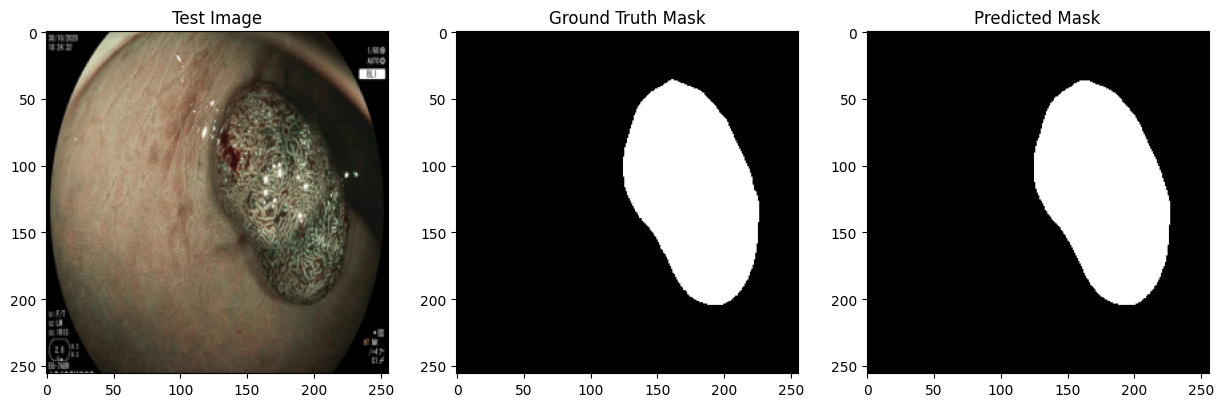

In [26]:
import matplotlib.pyplot as plt
import random

# Select a random test image
index = random.randint(0, len(x_test) - 1)

plt.figure(figsize=(15, 5))

# Original test image
plt.subplot(1, 3, 1)
plt.imshow(x_test[index])
plt.title("Test Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[index, :, :, 0], cmap='gray')
plt.title("Ground Truth Mask")

# Predicted mask (thresholded)
plt.subplot(1, 3, 3)
plt.imshow(y_pred_thresholded[index, :, :, 0], cmap='gray')
plt.title("Predicted Mask")

plt.show()
